In [1]:
import os
import shutil
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import random


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)



2.6.4


In [2]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [5]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
# Random seed for reproducibility
seed = 123

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
# Each species' pictures are stored in a separate directory which
# names are as follows:
labels = [
    "Species1",
    "Species2",
    "Species3",
    "Species4",
    "Species5",
    "Species6",
    "Species7",
    "Species8"
]

In [9]:
initial_dataset_dir = '../input/plant-species/images'

total :  3542


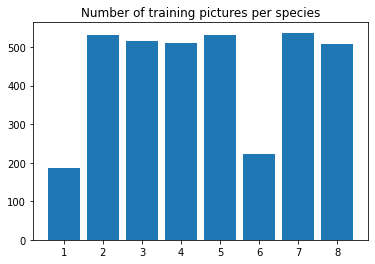

In [10]:
number_by_species={}
total_images=0

label_counts = []
for species in labels:
    n=len(os.listdir("{}/{}/".format(initial_dataset_dir, species)))
    number_by_species[species]=n
    total_images=total_images+n
    label_counts.append(n)

plt.bar(np.arange(1,9), label_counts)
plt.title("Number of training pictures per species")
print("total : ",total_images)

# Data processing

## Creating the training/validation split of the dataset

In [13]:
if (os.path.exists('./dataset')==False):
    os.mkdir('./dataset')
    

new_dataset_dir='./dataset'
validation_split=0.2
num_species=8
n_total=3542



In [14]:
# To be done one time, can be reexecuted without any problem

# Random training/val split, by splitting equally each species

train_subset=[]
valid_subset=[]

def create_folders():
    path_train=os.path.join(new_dataset_dir,'training')
    path_valid=os.path.join(new_dataset_dir,'validation')
    isExist_train = os.path.exists(path_train)
    isExist_valid = os.path.exists(path_valid)
    if (isExist_train==False):
        os.mkdir(path_train)
    if (isExist_valid==False):
        os.mkdir(path_valid)
    
    for i in range(1,num_species+1):
        path_train_i=os.path.join(new_dataset_dir,'training/Species'+str(i))
        path_valid_i=os.path.join(new_dataset_dir,'validation/Species'+str(i))
        isExist_train_i = os.path.exists(path_train_i)
        isExist_valid_i = os.path.exists(path_valid_i)
        if (isExist_train_i==False):
            os.mkdir(path_train_i)
        if (isExist_valid_i==False):
            os.mkdir(path_valid_i)
    



def clear_folder(mydir):
    filelist = [ f for f in os.listdir(mydir) ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))


create_folders()


for i in range(1,num_species+1):
    
    training_species_i=os.path.join(new_dataset_dir,'training/Species'+str(i))
    valid_species_i=os.path.join(new_dataset_dir,'validation/Species'+str(i))
    clear_folder(training_species_i)
    clear_folder(valid_species_i)
    
    filenames = next(os.walk(os.path.join(initial_dataset_dir,'Species'+str(i))))[2]   
#     random.Random(seed).shuffle(filenames)
    np.random.shuffle(filenames)
    num_valid_samples = int(len(filenames)*validation_split)
    add_to_train=filenames[:-num_valid_samples]
    add_to_valid=filenames[-num_valid_samples:]
    train_subset = train_subset+add_to_train
    valid_subset = valid_subset+add_to_valid
    for name in add_to_train:
        shutil.copy(os.path.join(initial_dataset_dir,'Species'+str(i)+'/'+name),training_species_i)    
    for name in add_to_valid:
        shutil.copy(os.path.join(initial_dataset_dir,'Species'+str(i)+'/'+name),valid_species_i)
    
    
        

print(len(train_subset))
print(len(valid_subset))
print(len(train_subset)+len(valid_subset))

2836
706
3542


## Balancing the dataset

In [ ]:
# Why balancing only the training datasets and not the val ones :

In [15]:
# # FIRST APPROACH : OVERSAMPLING

# import random

# # We randomly duplicate image from the minoritary species until their number reach the max one among
# # all the initial number_by_species.

# max_number_by_species = (int) (max(number_by_species.values())*(1-validation_split))+1

# for i in range(1,9):
#     dir_species_i='./dataset/training/Species'+str(i)
#     filenames=os.listdir(dir_species_i)
#     file_to_duplicate_names=[]
#     number=len(filenames)
#     q=max_number_by_species//number
#     r=max_number_by_species%number
#     if (q>1):
#         file_to_duplicate_names=(q-1)*filenames
    
#     for i in range (r):       
#         to_add=filenames[i]
#         file_to_duplicate_names.append(to_add)
#     random.Random(seed).shuffle(file_to_duplicate_names)
    
#     print(len(file_to_duplicate_names))
#     name_occur={}
#     for name in filenames:
#         name_occur[name]=1
    
   
#     for name in file_to_duplicate_names:
        
#         shutil.copy(dir_species_i+'/'+name,dir_species_i+'/'+name+str(name_occur[name]))
#         name_occur[name]=name_occur[name]+1
        
 
        
    
    
# # =====> Duplicate images from the training dataset mult times might involve overfitting ?
# # cf noaug_basic_model performances on curve
    
    

    
    

In [13]:
# # ALTERNATIVELY TRYING UNDERSAMPLING


# min_number_by_species = (int) (min(number_by_species.values())*(1-validation_split))+1

# for i in range(1,9):
#     dir_species_i='./dataset/training/Species'+str(i)
#     filenames=os.listdir(dir_species_i)
#     number=len(filenames)
#     np.random.shuffle(filenames)
#     for k in range(min_number_by_species,number):
#         os.remove('./dataset/training/Species'+str(i)+'/'+filenames[k])
    
 



In [16]:
T=0
V=0


for i in range(1,9):
    t=len(os.listdir('/kaggle/working/dataset/training/Species'+str(i)))
    v=len(os.listdir('/kaggle/working/dataset/validation/Species'+str(i)))
    T=T+t
    V=V+v
    print("Species "+str(i)+" :")
    print()
    print("training : ",t, " elements ; validation : ",v," elements ; total : ",v+t, " elements" )
    print("----------------------------------------------------------")
    
print()
print("There is at total ",(T,V), " elements in dataset")

Species 1 :

training :  149  elements ; validation :  37  elements ; total :  186  elements
----------------------------------------------------------
Species 2 :

training :  426  elements ; validation :  106  elements ; total :  532  elements
----------------------------------------------------------
Species 3 :

training :  412  elements ; validation :  103  elements ; total :  515  elements
----------------------------------------------------------
Species 4 :

training :  409  elements ; validation :  102  elements ; total :  511  elements
----------------------------------------------------------
Species 5 :

training :  425  elements ; validation :  106  elements ; total :  531  elements
----------------------------------------------------------
Species 6 :

training :  178  elements ; validation :  44  elements ; total :  222  elements
----------------------------------------------------------
Species 7 :

training :  430  elements ; validation :  107  elements ; total :  537 

In [17]:
training_dir = os.path.join(new_dataset_dir, 'training')
validation_dir = os.path.join(new_dataset_dir, 'validation')
batch_size=32

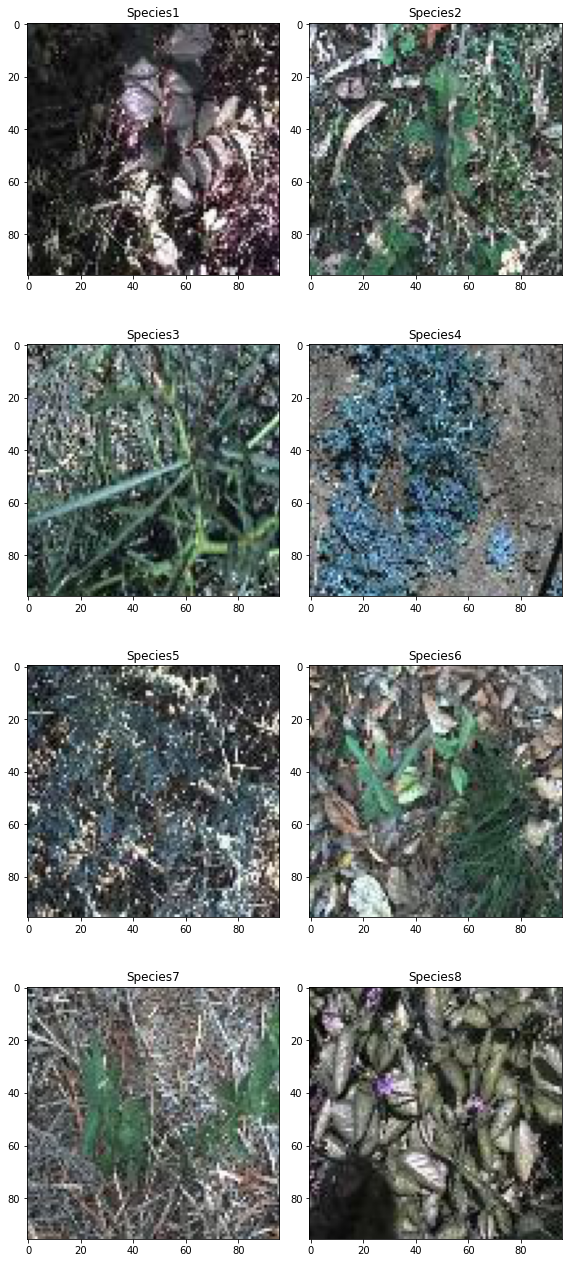

In [18]:
#vizualising data 

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]        # 20

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/training/{}/'.format(new_dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    
    img = Image.open('{}/training/{}/{}'.format(new_dataset_dir, labels[i], class_img))

    
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Data loading and augmentation

In [ ]:
#######    IMPORTANT   #######

# Note: each Keras Application expects a specific kind of input preprocessing. For ResNet, call 
# tf.keras.applications.resnet.preprocess_input on your inputs before passing them to the model.
# resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center 
# each color channel with respect to the ImageNet dataset, without scaling.

# The default input image size for this model is 224*224

#######                #######


In [49]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


# Image data generators with data augmentation, adapted to VGG19 which already have a preprocess


# Create an instance of ImageDataGenerator with Data Augmentation for training
aug_train_data_gen = ImageDataGenerator(rotation_range=60,
                                        height_shift_range=50, 
                                        width_shift_range=50,
                                        zoom_range=0.3,#slight ? might confuse bbtw species?
                                        horizontal_flip=False,
                                        vertical_flip=False,#init true but doesn't make sense to have a plant upside down??
                                        brightness_range=(0.3,1),
                                        fill_mode='reflect'
                                       ) # rescale value is multiplied to the image

# Flips are very suss ????

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed,
                                                       target_size=(96, 96)
                                                       
                                                      )


noaug_train_data_gen = ImageDataGenerator()
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed,
                                                       target_size=(96, 96)    
                                                       
                                                      )



valid_data_gen = ImageDataGenerator()



valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed,
                                              target_size=(96, 96))





Found 2836 images belonging to 8 classes.
Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [20]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


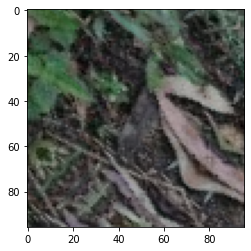

In [22]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

# Training the network

## Building the whole architecture

In [23]:
input_shape = (96, 96, 3)
epochs = 200
batch_size=32

In [24]:
class_loss_weights = {
    species: (1 / number_by_species['Species'+str(species+1)]) * (total_images / num_species) for species in range(num_species)
}
class_loss_weights

{0: 2.3803763440860215,
 1: 0.8322368421052632,
 2: 0.8597087378640776,
 3: 0.8664383561643835,
 4: 0.833804143126177,
 5: 1.9943693693693694,
 6: 0.824487895716946,
 7: 0.8715551181102362}

In [25]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name,patience):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [50]:
# Above part of the model

pooling='avg'

from tensorflow.keras.applications import ResNet50



above_model = ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=(224,224,3),
                       pooling=pooling
                      )

above_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [51]:
# MODEL_GAP: with falttening layer at the supernet output(+dense+dense)

above_model.trainable = False

inputs = tfk.Input(shape=(96,96,3))

x = tfkl.Resizing(224, 224)(inputs)
x=preprocess_input(x)
x = above_model(x, training=False)


x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)



x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
model_gap = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model_gap.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.001), metrics='accuracy')
model_gap.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing_4 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_5 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               104908

In [52]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='ResNet50_gap_aug',patience=30)


# Train the model
history = model_gap.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
    class_weight=class_loss_weights
       
   

).history

Epoch 1/200
89/89 [==============================] - 20s 189ms/step - loss: 1.6666 - accuracy: 0.4267 - val_loss: 0.9054 - val_accuracy: 0.6728
Epoch 2/200
89/89 [==============================] - 16s 176ms/step - loss: 1.2668 - accuracy: 0.5434 - val_loss: 0.9148 - val_accuracy: 0.6686
Epoch 3/200
89/89 [==============================] - 16s 175ms/step - loss: 1.2140 - accuracy: 0.5610 - val_loss: 0.7968 - val_accuracy: 0.7167
Epoch 4/200
89/89 [==============================] - 16s 174ms/step - loss: 1.1291 - accuracy: 0.5769 - val_loss: 0.7669 - val_accuracy: 0.7139
Epoch 5/200
89/89 [==============================] - 15s 170ms/step - loss: 1.0921 - accuracy: 0.6065 - val_loss: 0.7971 - val_accuracy: 0.7068
Epoch 6/200
89/89 [==============================] - 16s 177ms/step - loss: 1.0604 - accuracy: 0.6181 - val_loss: 0.7479 - val_accuracy: 0.7195
Epoch 7/200
89/89 [==============================] - 15s 171ms/step - loss: 1.0375 - accuracy: 0.6195 - val_loss: 0.7202 - val_accuracy:

Confusion Matrix
              precision    recall  f1-score   support

    Species1       0.74      0.54      0.62        37
    Species2       0.82      0.85      0.83       106
    Species3       0.85      0.90      0.87       103
    Species4       0.86      0.76      0.81       102
    Species5       0.88      0.86      0.87       106
    Species6       0.89      0.89      0.89        44
    Species7       0.92      0.92      0.92       107
    Species8       0.72      0.82      0.77       101

    accuracy                           0.84       706
   macro avg       0.83      0.82      0.82       706
weighted avg       0.84      0.84      0.84       706



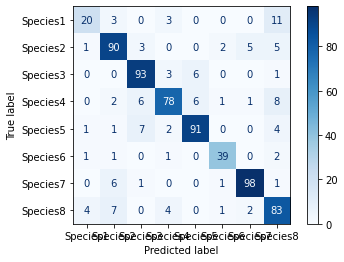

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Confution Matrix and Classification Report
# Y_pred = model_gap.predict_generator(valid_gen,  706// batch_size+1)
Y_pred = model_gap.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(valid_gen.classes, y_pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(valid_gen.classes, y_pred, target_names=labels))


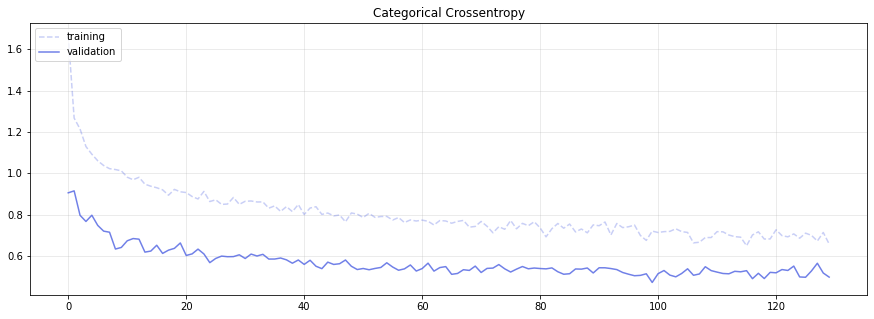

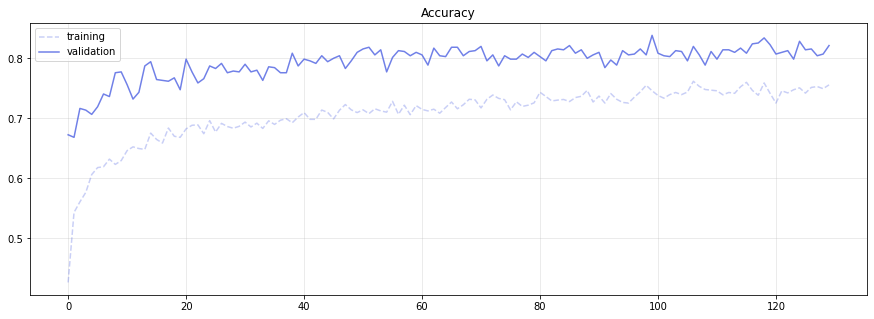

In [55]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig('cat_crossentropy_evol')

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('accuracy_evol')
plt.show()

In [56]:
# Save best epoch model
model_gap.save("ResNet50_frozen")

In [57]:
import shutil
shutil.make_archive("ResNet50_frozen", 'zip', './ResNet50_frozen')   

'/kaggle/working/ResNet50_frozen.zip'

In [ ]:
# Data augmentation with too intense transformations induces that the accuracy
# On the training set increase very slowly (bc it's always a 'very' different set
# that is seen) ==> find a compromise btw too low (no improvt, overfitting) 
# and too intense transfo

In [60]:
#Fine tuning the model 

# Unfreeze the base model

above_model.trainable=True

model_gap.compile(optimizer=tfk.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')

aug_callbacks = create_folders_and_callbacks(model_name='ResNet50_fine_tuning',patience=30)

history_bis = model_gap.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks, 
    class_weight=class_loss_weights
     
).history

Epoch 1/200
89/89 [==============================] - 38s 367ms/step - loss: 0.7176 - accuracy: 0.7387 - val_loss: 0.5189 - val_accuracy: 0.8003
Epoch 2/200
89/89 [==============================] - 32s 358ms/step - loss: 0.6852 - accuracy: 0.7627 - val_loss: 0.4793 - val_accuracy: 0.8300
Epoch 3/200
89/89 [==============================] - 32s 355ms/step - loss: 0.6190 - accuracy: 0.7747 - val_loss: 0.5170 - val_accuracy: 0.8314
Epoch 4/200
89/89 [==============================] - 32s 357ms/step - loss: 0.6306 - accuracy: 0.7754 - val_loss: 0.4249 - val_accuracy: 0.8555
Epoch 5/200
89/89 [==============================] - 32s 362ms/step - loss: 0.5452 - accuracy: 0.8047 - val_loss: 0.4337 - val_accuracy: 0.8456
Epoch 6/200
89/89 [==============================] - 32s 356ms/step - loss: 0.5474 - accuracy: 0.8032 - val_loss: 0.4644 - val_accuracy: 0.8385
Epoch 7/200
89/89 [==============================] - 32s 361ms/step - loss: 0.5455 - accuracy: 0.8110 - val_loss: 0.4618 - val_accuracy:

Confusion Matrix
              precision    recall  f1-score   support

    Species1       0.71      0.65      0.68        37
    Species2       0.94      0.96      0.95       106
    Species3       0.94      0.97      0.96       103
    Species4       0.88      0.93      0.90       102
    Species5       0.93      0.91      0.92       106
    Species6       0.95      0.93      0.94        44
    Species7       0.97      0.99      0.98       107
    Species8       0.92      0.86      0.89       101

    accuracy                           0.92       706
   macro avg       0.91      0.90      0.90       706
weighted avg       0.92      0.92      0.92       706



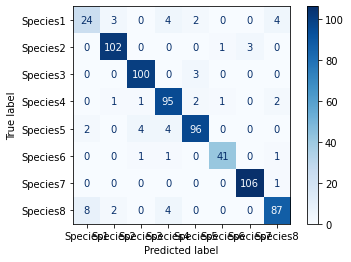

In [61]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_gap.predict_generator(valid_gen,  706// batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(valid_gen.classes, y_pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(valid_gen.classes, y_pred, target_names=labels))


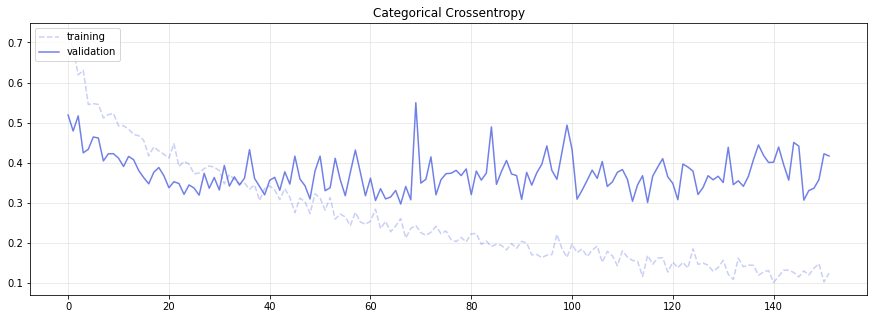

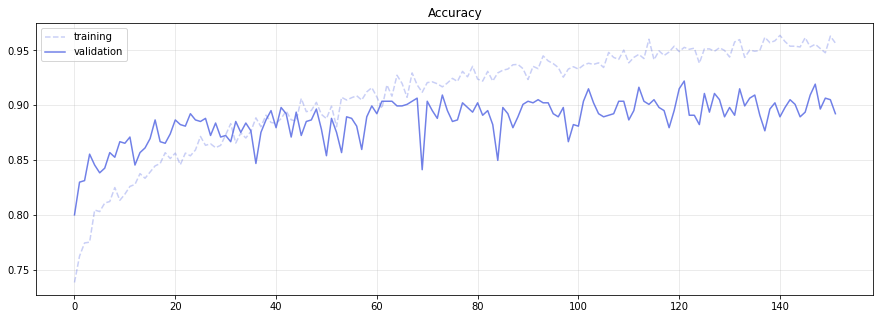

In [62]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history_bis['loss'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_bis['val_loss'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig('cat_crossentropy_evol')

plt.figure(figsize=(15,5))
plt.plot(history_bis['accuracy'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_bis['val_accuracy'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('accuracy_evol')
plt.show()

In [64]:
# Save best epoch model
model_gap.save("ResNet50_2")
shutil.make_archive("ResNet50_2", 'zip', './ResNet50_2') 

'/kaggle/working/ResNet50_2.zip'

## Training loaded models

In [63]:
loaded_model=tfk.models.load_model('././ResNet50_frozen')
loaded_model.evaluate(valid_gen)

23/23 [==============================] - 3s 89ms/step - loss: 0.4721 - accuracy: 0.8385


[0.47214338183403015, 0.8385269045829773]

Confusion Matrix
              precision    recall  f1-score   support

    Species1       0.74      0.54      0.62        37
    Species2       0.82      0.85      0.83       106
    Species3       0.85      0.90      0.87       103
    Species4       0.86      0.76      0.81       102
    Species5       0.88      0.86      0.87       106
    Species6       0.89      0.89      0.89        44
    Species7       0.92      0.92      0.92       107
    Species8       0.72      0.82      0.77       101

    accuracy                           0.84       706
   macro avg       0.83      0.82      0.82       706
weighted avg       0.84      0.84      0.84       706



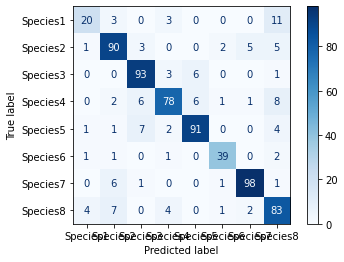

In [65]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = loaded_model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(valid_gen.classes, y_pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(valid_gen.classes, y_pred, target_names=labels))


In [68]:
# #Fine tuning (again?) the loaded_model (with slight data augm to avoid overfitt?)

# # Unfreeze the base model

# loaded_model.layers[4].trainable=True

# loaded_model.compile(optimizer=tfk.optimizers.Adam(1e-4),  # Very low learning rate
#               loss=tfk.losses.CategoricalCrossentropy(),
#               metrics='accuracy')

# aug_callbacks = create_folders_and_callbacks(model_name='ResNet50_fine_tuning*2',patience=30)


# history_bis = loaded_model.fit(
#     x = aug_train_gen,
#     epochs = 200,
#     validation_data = valid_gen,
#     callbacks = aug_callbacks, 
#     class_weight=class_loss_weights
    
# ).history